In [1]:
import tweepy
import csv
import sys
import datetime
import textblob
import tweepy
import pandas
import sys
from textblob import TextBlob
import re
import io
import csv
import tweepy as tw
from tweepy import OAuthHandler
import pandas as pd

In [2]:
consumer_key = "YOUR CONSUMER KEY"
consumer_secret = "YOUR CONSUMER SECRET"

access_token = "YOUR ACCESS TOKEN"
access_token_secret = "YOUR ACCESS TOKEN SECRET KEY"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# Open/Create a file to append data
csvFile = open(sys.argv[1]+'tweets.csv', 'a')
#Use csv Writer
fields = ('date','text', 'followers')
csvWriter = csv.writer(csvFile, lineterminator= '\n')

for tweet in tweepy.Cursor(api.search,q='#Twitter', count=20000, lang="en", since_id="2015-10-10").items():
    print(tweet.created_at, tweet.text)
    follower_count = tweet.user.followers_count
    #if tweet.created_at >= datetime.datetime:
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8'),follower_count])

In [7]:
#perform sentiment anlaysis on tweets
api = tweepy.API(auth)
colnames=['date', 'text', 'followers']

df = pandas.read_csv(sys.argv[1]+'tweets.csv',encoding='latin-1', names=colnames, header=None)
df['polarity'] = 0.0000
df['sentiment_confidence'] = 0.0000

for index,row in df.iterrows():
    analysis = TextBlob(df['text'][index])
    sentiment, confidence = analysis.sentiment
    df.at[index,'polarity'] = sentiment
    df.at[index,'sentiment_confidence'] = confidence

df.to_csv(sys.argv[1]+'sentiment.csv')

                  date  followers  polarity  sentiment_confidence
0  2020-10-10 14:47:04        922 -0.300000                 0.400
1  2020-10-10 14:46:53        232  0.136364                 0.500
2  2020-10-10 14:46:50         51 -0.208333                 0.375
3  2020-10-10 14:46:50      20970  0.000000                 0.000
4  2020-10-10 14:46:45        337  0.000000                 0.000
   followers  polarity  sentiment_confidence
0        922 -0.300000                 0.400
1        232  0.136364                 0.500
2         51 -0.208333                 0.375
3      20970  0.000000                 0.000
4        337  0.000000                 0.000


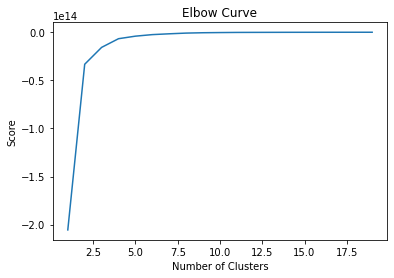

In [113]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# perform analysis with an elboy curve for clustering

df = pd.read_csv(sys.argv[1]+'sentiment.csv',index_col=0, encoding='latin-1')
dfold = df
df = df.drop('text', 1)
print(df.head())
df = df.drop('date', 1)
print(df.head())

df_tr = df
# select proper number of clusters

Y = df[['followers']]
X = df[['polarity']]

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


#Elbow curve seems to drop off a 5 clusters after removing irrelevant values
#Dropped text and date of tweets because these values hold no value quantitatively
#Follower count and polarity more relevant for impact of tweet 

             followers  polarity  sentiment_confidence
clusters                                              
0         1.105330e+04  0.638879              0.677219
1         9.528271e+03  0.003390              0.019936
2         7.584741e+06  0.224074              0.298148
3         5.075443e+03  0.197135              0.419613
4         2.390866e+03 -0.259343              0.531422


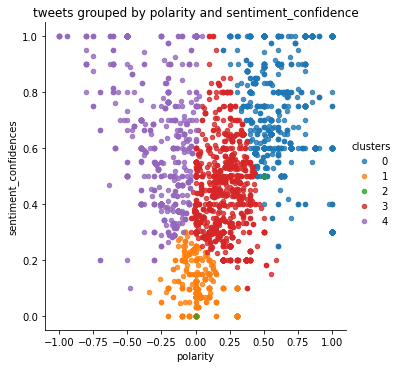

In [122]:
#Standardize

clmns = ['followers', 'polarity', 'sentiment_confidence']

df_tr_std= stats.zscore(df_tr[clmns])

#Clustering

kmeans = KMeans(n_clusters=5, random_state=0).fit(df_tr_std)
labels = kmeans.labels_

#Glue back to original data
df_tr['clusters']=labels
dfold['clusters']=labels

clmns.extend(['clusters'])

print(df_tr[clmns].groupby(['clusters']).mean())

#Scatter plot of polarity and confidence
sns.lmplot('polarity', 'sentiment_confidence',
           data=df_tr,
           fit_reg=False,
           hue="clusters",
           scatter_kws={"marker": "D",
                        "s": 20})

dfold.to_csv(sys.argv[1]+'cluster.csv')
plt.title('tweets grouped by polarity and sentiment_confidence')
plt.xlabel('polarity')
plt.ylabel('sentiment_confidences')
plt.show()

In [ ]:
#Merge Cluster csv with stock data
merged_cluster_stock_csv = ('final.csv')
df = [merged_cluster_stock_csv]

In [197]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [198]:
# Set path to CSV and read in CSV
csv_path = Path('final.csv')
twitter_sentiment_df=pd.read_csv(csv_path)
twitter_sentiment_df

,Unnamed: 0,followers,polarity,sentiment_confidence,clusters,Date,High,Low,Open,Close,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,nvi_ema
0,0,922.0,-0.300000,0.400,4.0,10/5/15,28.250000,26.330000,26.99,28.150000,...,94.791647,94.791647,-5.208353,0.0,28.150000,0.0,3.517172,0.000000,0.000000,1000.000000
1,1,232.0,0.136364,0.500,3.0,10/6/15,28.400000,26.750000,28.16,27.620001,...,62.318894,78.555270,-37.681106,0.0,27.955291,0.0,-1.882767,-1.900716,-1.882767,1000.000000
2,2,51.0,-0.208333,0.375,4.0,10/7/15,29.950001,28.010000,28.35,29.830000,...,96.685060,84.598534,-3.314940,0.0,28.302700,0.0,8.001445,7.697442,5.968030,1000.000000
3,3,20970.0,0.000000,0.000,1.0,10/8/15,31.500000,29.030001,29.57,30.320000,...,77.176010,78.726655,-22.823990,0.0,28.672443,0.0,1.642641,1.629295,7.708704,1000.000000
4,4,337.0,0.000000,0.000,1.0,10/9/15,31.410000,30.280001,30.90,30.850000,...,87.427474,87.096181,-12.572526,0.0,29.045544,0.0,1.748023,1.732921,9.591477,1003.551759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,1255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9965,1256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9966,1257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9967,1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
# Drop NAs and calculate daily percent return
twitter_sentiment_df['daily_return'] = twitter_sentiment_df['Close'].dropna().pct_change()
twitter_sentiment_df

,Unnamed: 0,followers,polarity,sentiment_confidence,clusters,Date,High,Low,Open,Close,...,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,nvi_ema,daily_return
0,0,922.0,-0.300000,0.400,4.0,10/5/15,28.250000,26.330000,26.99,28.150000,...,94.791647,-5.208353,0.0,28.150000,0.0,3.517172,0.000000,0.000000,1000.000000,NaN
1,1,232.0,0.136364,0.500,3.0,10/6/15,28.400000,26.750000,28.16,27.620001,...,78.555270,-37.681106,0.0,27.955291,0.0,-1.882767,-1.900716,-1.882767,1000.000000,-0.018828
2,2,51.0,-0.208333,0.375,4.0,10/7/15,29.950001,28.010000,28.35,29.830000,...,84.598534,-3.314940,0.0,28.302700,0.0,8.001445,7.697442,5.968030,1000.000000,0.080014
3,3,20970.0,0.000000,0.000,1.0,10/8/15,31.500000,29.030001,29.57,30.320000,...,78.726655,-22.823990,0.0,28.672443,0.0,1.642641,1.629295,7.708704,1000.000000,0.016426
4,4,337.0,0.000000,0.000,1.0,10/9/15,31.410000,30.280001,30.90,30.850000,...,87.096181,-12.572526,0.0,29.045544,0.0,1.748023,1.732921,9.591477,1003.551759,0.017480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,1255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9965,1256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9966,1257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9967,1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
twitter_sentiment_df = twitter_sentiment_df[['polarity']].copy()

In [204]:
trigger = 100
for index, row in twitter_sentiment_df.iterrows():
    if trigger == 100:
        twitter_sentiment_df.loc[index, "nlp_signal"] = "1"
    elif row["polarity"] > 0 :
        twitter_sentiment_df.loc[index, "nlp_signal"] = "1"
    elif row["polarity"] < 0:
        twitter_sentiment_df.loc[index, "nlp_signal"] = "-1"
    else:
        twitter_sentiment_df.loc[index, "nlp_signal"] = "0"
    trigger = row["polarity"]

twitter_sentiment_df

,polarity,nlp_signal
0,-0.300000,1
1,0.136364,1
2,-0.208333,-1
3,0.000000,0
4,0.000000,0
...,...,...
9964,NaN,0
9965,NaN,0
9966,NaN,0
9967,NaN,0


In [206]:
twitter_sentiment_df.to_csv("twtr_nlp_data.csv")